In [1]:
import os
import math
import numpy as np
import string

import openrtdynamics2.lang as dy
import openrtdynamics2.py_execute as dyexe
import openrtdynamics2.code_generation_helper as cgh
from openrtdynamics2.targets import TargetTemplate
from openrtdynamics2.manifest_import import get_all_inputs, get_all_outputs

from textwrap import indent


# A manually defined target for a fixed set of system in- and outputs

In [2]:
class CppMainManual(TargetTemplate):
    """
        generate a simple main.cpp programm
    """

    def __init__(self, enable_tracing=False ):
        TargetTemplate.__init__(self, enable_tracing)

    def code_gen(self):
        # build code of system        
        res = TargetTemplate.code_gen(self)
        
        headers = '#include <stdio.h>\n'
        
        main_fn = """
int main () {

    simulation system_instance;

    simulation::Inputs inputs;
    simulation::Outputs outputs;
    
    // set const inputs
    inputs.u1 = 1;
    inputs.u2 = 2;
    
    // reset system
    system_instance.step( outputs, inputs, false, false, true );
    
    int i_max = 10;
    
    for (int i = 0; i < i_max; ++i) {
        
        // calculate outputs
        system_instance.step( outputs, inputs, true, false, false );
        
        // update states
        system_instance.step( outputs, inputs, false, true, false );
    
        // print outputs
        printf("%2.3f %2.3f\\n", outputs.y1, outputs.y2);
    } 
    
    return 0;
}
        
        """
        
        #
        # build main.cpp
        #
        main_cpp = headers + '\n' + res['algorithm_sourcecode'] + '\n' + main_fn
        
        self.files['main.cpp'] = main_cpp
        
        # return
        return res

In [3]:
dy.clear()

system = dy.enter_system()

# define system inputs
u1               = dy.system_input( dy.DataTypeFloat64(1), name='u1', default_value=1.0,  value_range=[0, 25], title="input #1")
u2               = dy.system_input( dy.DataTypeFloat64(1), name='u2', default_value=2.0,  value_range=[0, 25], title="input #2")


y1 = dy.signal()                         # introduce variable y
x = y1 + u1                              # x[k] = y[k] + u[k]
y1 << dy.delay(x, initial_state = 2.0)   # y[k+1] = y[k] + x[k], y[0] = 2.0

# some second output
y2 = y1 + u2

# define output(s)
dy.append_output(y1, 'y1')
dy.append_output(y2, 'y2')

# generate code using the target defined above
code_gen_results = dy.generate_code(template=CppMainManual(), folder='generated/test_CppMainManual')

compiling system simulation (level 0)... 
Generated code will be written to generated/test_CppMainManual .
writing file generated/test_CppMainManual/simulation_manifest.json
writing file generated/test_CppMainManual/main.cpp


# A custom target for a variable set of system in- and outputs

In [4]:
class TargetCppMain(TargetTemplate):
    """
        generate a simple main.cpp programm
    """

    def __init__(self, i_max = 20, enable_tracing=False ):
        
        TargetTemplate.__init__(self, enable_tracing)
        self.i_max = i_max

    def build(self):
        
        main_cpp    = os.path.join( self.folder, 'main.cpp' )
        main_binary = os.path.join( self.folder, 'main' )
        build_command = "c++ " + main_cpp + " -o " + main_binary
        
        print("Running build command: " + build_command)
        
        return_code = os.system(build_command)
        print( "Compilation result: ", return_code )
        
        
    def code_gen(self):
        # build code of system
        res = TargetTemplate.code_gen(self)
        
        # get the system manifest and c++ class name
        m = res['manifest']
        simulation_name = m['api_name']
        
        # headers
        headers = '#include <stdio.h>\n'
        
        # define structs for I/O
        variables = simulation_name + ' system_instance;\n' + simulation_name + '::Inputs inputs;\n' + simulation_name + '::Outputs outputs;\n'
        
        
        #
        # create a list of the system inputs
        #
        
        inputs = get_all_inputs( m, only_inputs_with_default_values = True )

        fill_input_values = ''
        for input_name, v in inputs.items():
            
            print(input_name, v['properties']['default_value'], v['cpptype'])
            
            fill_input_values += 'inputs.' + input_name + ' = ' + str( v['properties']['default_value'] ) + ';\n' #, v['cpptype']

        #
        # create a list of the system outputs and a printf to print the data
        #
        
        outputs = get_all_outputs( m )

        printf_patterns   = []
        printf_parameters = []
        
        for output_name, v in outputs.items():
            printf_patterns.append( v['printf_pattern'] )
            printf_parameters.append( 'outputs.' + output_name )
            
        
        outputs_printf = 'printf("' + ' '.join(printf_patterns) + '\\n", ' + ', '.join(printf_parameters) + ');\n'
        
        #
        # template code
        #
        
        main_fn = """
int main () {
""" + indent(variables, '    ') + """
    
    // set const inputs
""" + indent(fill_input_values, '    ') + """
    
    // reset system
    system_instance.step( outputs, inputs, false, false, true );
    
""" + indent('int i_max = ' + str(self.i_max) + ';\n', '    ') + """
    
    for (int i = 0; i < i_max; ++i) {
        
        // calculate outputs
        system_instance.step( outputs, inputs, true, false, false );
        
        // update states
        system_instance.step( outputs, inputs, false, true, false );
    
        // print outputs
""" + indent(outputs_printf, '        ') + """
    } 
    
    return 0;
}
        
        """
        
        #
        # build main.cpp
        #
        
        main_cpp = headers + '\n' + res['algorithm_sourcecode'] + '\n' + main_fn
        
        self.files['main.cpp'] = main_cpp
        
        # return
        return res

In [5]:
dy.clear()

system = dy.enter_system()

# define system inputs
u1               = dy.system_input( dy.DataTypeFloat64(1), name='u1', default_value=1.0,  value_range=[0, 25], title="input #1")
u2               = dy.system_input( dy.DataTypeFloat64(1), name='u2', default_value=2.0,  value_range=[0, 25], title="input #2")


y1 = dy.signal()                         # introduce variable y
x = y1 + u1                              # x[k] = y[k] + u[k]
y1 << dy.delay(x, initial_state = 2.0)   # y[k+1] = y[k] + x[k], y[0] = 2.0

# some second output
y2 = y1 + u2

# define output(s)
dy.append_output(y1, 'y1')
dy.append_output(y2, 'y2')

# generate code using the target defined above
code_gen_results = dy.generate_code(template=TargetCppMain(), folder='generated/test_CppMain', build=True)

compiling system simulation (level 0)... 
u2 2.0 double
u1 1.0 double
Generated code will be written to generated/test_CppMain .
writing file generated/test_CppMain/simulation_manifest.json
writing file generated/test_CppMain/main.cpp
Running build command: c++ generated/test_CppMain/main.cpp -o generated/test_CppMain/main
Compilation result:  0


### Results

The generated files and the output of the excutable shall look as follows:


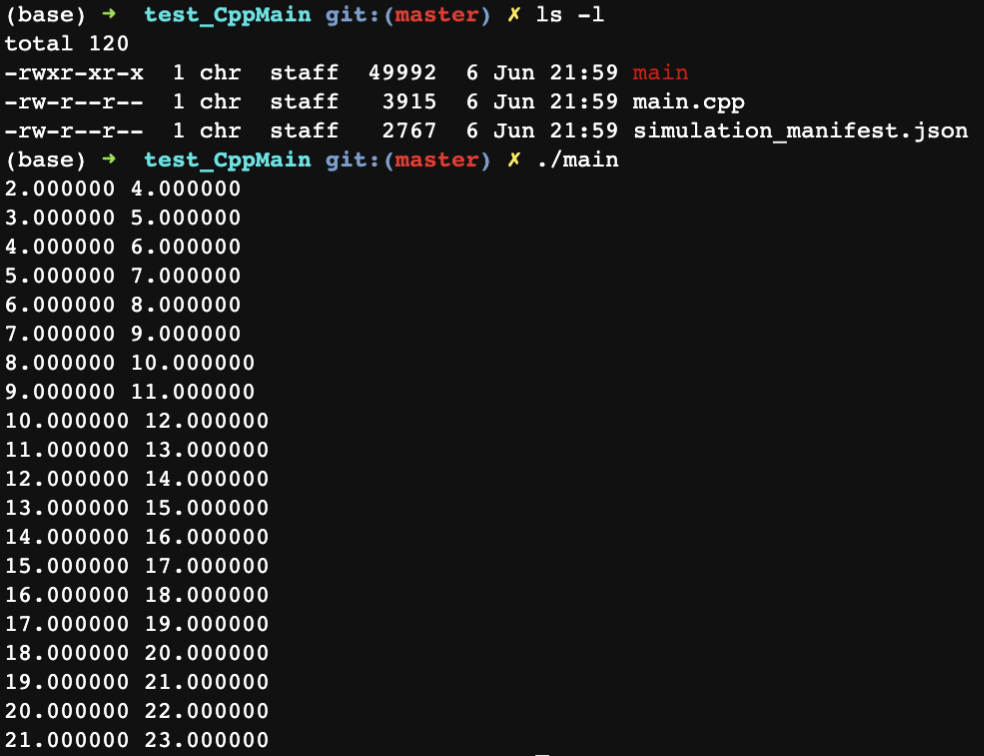


### Generated manifest and source code 

In [6]:
# show the manifest

from IPython.display import JSON, Code
JSON(code_gen_results['manifest'], expanded=True)

<IPython.core.display.JSON object>

In [7]:
# show the generated source code

Code(data=code_gen_results['files']['main.cpp'], language='c++')

#include <stdio.h>

// namespace for simulation {
  // global variables

  class simulation {
    public:


    // state update
    double block_2_mem;


    // state update


    //
    // cached output values
    //

    double y1__block_2;
    double y2__block_3;

    // API-function resetStates
    void resetStates() { // created by cpp_define_function

      block_2_mem = 2.0;
    }
    // output signals of  resetStates
    struct Outputs_resetStates{
      ;

    };
    // input signals of resetStates
    struct Inputs_resetStates{
      ;

    };
    // wrapper function for resetStates
    Outputs_resetStates resetStates__(Inputs_resetStates inputs) {
      Outputs_resetStates outputs;

      resetStates();

      return outputs;
    }
    // API-function updateStates
    void updateStates(double u1) { // created by cpp_define_function
      double s3;


      // restoring the signals y1, y2 from the states 
      double &y1 = y1__block_2;
      double &y2 = y2__block_3;


      // calculating the block outputs in the following order s3
      // that depend on u1
      // dependencies that require a state update are  

      s3 = y1 + u1;

      block_2_mem = s3;

      // calculating the block outputs in the following order 
      // that depend on 
      // dependencies that require a state update are  


    }
    // output signals of  updateStates
    struct Outputs_updateStates{
      ;

    };
    // input signals of updateStates
    struct Inputs_updateStates{
      double u1;

    };
    // wrapper function for updateStates
    Outputs_updateStates updateStates__(Inputs_updateStates inputs) {
      Outputs_updateStates outputs;

      updateStates(inputs.u1);

      return outputs;
    }
    // API-function calcResults_1 to compute: y1, y2
    void calcResults_1(double &y1, double &y2, double u2) { // created by cpp_define_function


      // calculating the block outputs in the following order y1, y2
      // that depend on u2
      // dependencies that require a state update are s3 

      y1 = block_2_mem;
      y2 = y1 + u2;

      // saving the signals y1, y2 into the states 
      y1__block_2 = y1;
      y2__block_3 = y2;
    }
    // output signals of  calcResults_1
    struct Outputs_calcResults_1{
      double y1;
      double y2;

    };
    // input signals of calcResults_1
    struct Inputs_calcResults_1{
      double u2;

    };
    // wrapper function for calcResults_1
    Outputs_calcResults_1 calcResults_1__(Inputs_calcResults_1 inputs) {
      Outputs_calcResults_1 outputs;

      calcResults_1(outputs.y1, outputs.y2,   inputs.u2);

      return outputs;
    }
    // all system inputs and outputs combined
    struct Inputs{
      double u2;
      double u1;

    };
    struct Outputs{
      double y1;
      double y2;

    };
    // main step function 
    void step(Outputs & outputs, Inputs const & inputs, int calculate_outputs, bool update_states, bool reset_states) {
      if (reset_states) {
        resetStates();

      }
      if (calculate_outputs==1) {
        calcResults_1(outputs.y1, outputs.y2,   inputs.u2);

      }
      if (update_states) {
        updateStates(inputs.u1);

      }

    }
  };

// end of namespace for simulation



int main () {
    simulation system_instance;
    simulation::Inputs inputs;
    simulation::Outputs outputs;

    
    // set const inputs
    inputs.u2 = 2.0;
    inputs.u1 = 1.0;

    
    // reset system
    system_instance.step( outputs, inputs, false, false, true );
    
    int i_max = 20;

    
    for (int i = 0; i < i_max; ++i) {
        
        // calculate outputs
        system_instance.step( outputs, inputs, true, false, false );
        
        // update states
        system_instance.step( outputs, inputs, false, true, false );
    
        // print outputs
        printf("%f %f\n", outputs.y1, outputs.y2);

    } 
    
    return 0;
}

# A target for Web assembly

This is a template that generates code than can be compiled with the compiler https://emscripten.org/. The result can then be called from Javascript in an HTML-page.

For details please consider: https://emscripten.org/docs/porting/connecting_cpp_and_javascript/embind.html

In [11]:

class TargetCppWASM(TargetTemplate):
    """
        Export to Web Assembly using the c++ compiler emscripten 
        
        https://emscripten.org/
    """

    def __init__(self, enable_tracing=False ):
        
        TargetTemplate.__init__(self, enable_tracing)

        
    def build(self):

        build_command = 'emcc --bind -s MODULARIZE=1 -s EXPORT_NAME="ORTD_simulator" '  + os.path.join(self.folder, "main.cpp") + " -O2 -s -o " + os.path.join( self.folder , "main.js" )
        print("Running compiler: " + build_command)

        return_code = os.system(build_command)
        print( "Compilation result: ", return_code )

        
        
    def code_gen(self):
        # build code of system
        res = TargetTemplate.code_gen(self)
        
        # get the system manifest and c++ class name
        m = res['manifest']
        simulation_name = m['api_name']
        
        # headers
        headers = """        
#include <math.h>
#include <stdio.h>
#include <emscripten/bind.h>

using namespace emscripten;
        """

        def generate_binding_code(system_cpp_class_name, struct_name : str, names ):

            lines = ''
            lines += 'value_object<' + system_cpp_class_name + '::' + struct_name + '>("' + system_cpp_class_name + '__' + struct_name + '")\n'

            for name in names:

                lines += '.field("' + name + '", &' + system_cpp_class_name + '::' + struct_name + '::' + name + ')\n'

            lines += ';\n\n'


            return lines        
        
        # define structs for I/O
        variables = simulation_name + ' system_instance;\n' + simulation_name + '::Inputs inputs;\n' + simulation_name + '::Outputs outputs;\n'
        
        
        #
        # create binding code to export the c++ API to Java Script
        #
        
        binding_code = """


// Binding code
EMSCRIPTEN_BINDINGS(my_class_example) {
  class_<$simulation_name>("$simulation_name")
    .constructor<>()
    .function("resetStates", &$simulation_name::resetStates__)
    .function("calcResults_1", &$simulation_name::calcResults_1__)
    .function("updateStates", &$simulation_name::updateStates__)
    .function("step", &$simulation_name::step)
    ;

        
"""
        
        binding_code = string.Template(binding_code).safe_substitute( simulation_name = simulation_name )
        
        binding_code += generate_binding_code(
            
            simulation_name, 
            'Inputs',
            
            get_all_inputs( 
                m,
                only_inputs_with_default_values    = False, 
                return_inputs_to_update_states     = True,
                return_inputs_to_calculate_outputs = True,
                return_inputs_to_reset_states      = True
            )
        )
        
        binding_code += generate_binding_code(
            
            simulation_name, 
            'Outputs',
            
            get_all_outputs( 
                m
            )
        )
        
        #
        
        binding_code += generate_binding_code(
            
            simulation_name, 
            'Inputs_' + m['api_functions']['calculate_output'],
            
            get_all_inputs( 
                m,
                only_inputs_with_default_values    = False, 
                return_inputs_to_update_states     = False,
                return_inputs_to_calculate_outputs = True,
                return_inputs_to_reset_states      = False
            )
        )

        binding_code += generate_binding_code(
            
            simulation_name, 
            'Outputs_' + m['api_functions']['calculate_output'],
            
            get_all_outputs( 
                m,
                return_inputs_to_update_states     = False,
                return_inputs_to_calculate_outputs = True,
                return_inputs_to_reset_states      = False
            )
        )

        
        
        binding_code += generate_binding_code(

            simulation_name, 
            'Inputs_' + m['api_functions']['state_update'],
            
            get_all_inputs( 
                m,
                only_inputs_with_default_values    = False, 
                return_inputs_to_update_states     = True,
                return_inputs_to_calculate_outputs = False,
                return_inputs_to_reset_states      = False
            )
        )

        binding_code += generate_binding_code(

            simulation_name, 
            'Outputs_' + m['api_functions']['state_update'],
            
            get_all_outputs( 
                m,
                return_inputs_to_update_states     = True,
                return_inputs_to_calculate_outputs = False,
                return_inputs_to_reset_states      = False
            )
        )




        binding_code += generate_binding_code(

            simulation_name, 
            'Inputs_' + m['api_functions']['reset'],
            
            get_all_inputs( 
                m,
                return_inputs_to_update_states     = False,
                return_inputs_to_calculate_outputs = False,
                return_inputs_to_reset_states      = True
            )
        )
        
        binding_code += generate_binding_code(

            simulation_name, 
            'Outputs_' + m['api_functions']['reset'],
            
            get_all_outputs( 
                m,
                return_inputs_to_update_states     = False,
                return_inputs_to_calculate_outputs = False,
                return_inputs_to_reset_states      = True
            )
        )
        
        
        binding_code += '\n}\n'
        
        #
        # template code
        #
        
        main_fn = binding_code
        
        #
        # build main.cpp
        #
        
        main_cpp = headers + '\n' + res['algorithm_sourcecode'] + '\n' + main_fn
        
        self.files['main.cpp'] = main_cpp
        
        # return
        return res

In [12]:
dy.clear()

system = dy.enter_system()

# define system inputs
u1               = dy.system_input( dy.DataTypeFloat64(1), name='u1', default_value=1.0,  value_range=[0, 25], title="input #1")
u2               = dy.system_input( dy.DataTypeFloat64(1), name='u2', default_value=2.0,  value_range=[0, 25], title="input #2")


y1 = dy.signal()                         # introduce variable y
x = y1 + u1                              # x[k] = y[k] + u[k]
y1 << dy.delay(x, initial_state = 2.0)   # y[k+1] = y[k] + x[k], y[0] = 2.0

# some second output
y2 = y1 + u2

# define output(s)
dy.append_output(y1, 'y1')
dy.append_output(y2, 'y2')

# generate code using the target defined above
code_gen_results = dy.generate_code(template=TargetCppWASM(), folder='generated/test_CppWASM', build=True)

compiling system simulation (level 0)... 
Generated code will be written to generated/test_CppWASM .
writing file generated/test_CppWASM/simulation_manifest.json
writing file generated/test_CppWASM/main.cpp
Running compiler: emcc --bind -s MODULARIZE=1 -s EXPORT_NAME="ORTD_simulator" generated/test_CppWASM/main.cpp -O2 -s -o generated/test_CppWASM/main.js
Compilation result:  0


In [10]:
# show the generated source code

# Code(data=code_gen_results['files']['main.cpp'], language='c++')